Split training data into correct folders
--------------------------------------

In [1]:
sort_data = None

%matplotlib inline
from __future__ import division,print_function
import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
from utils import *
from vgg16 import Vgg16

path = 'data/invasive-species-monitoring/'
labels = np.genfromtxt(path + 'train_labels.csv', dtype=None, delimiter=',', names=True)

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [2]:
def cpRandomJpgs(frm, to, num):
    %mkdir -p {path + to}
    g = glob(path + frm + '/*.jpg')
    shuf = np.random.permutation(g)
    for i in range(num):
        %cp {shuf[i]} {path + to + '/.'}

def mvRandomJpgs(frm, to, num):
    %mkdir -p {path + to}
    g = glob(path + frm + '/*.jpg')
    shuf = np.random.permutation(g)
    for i in range(num):
        %mv {shuf[i]} {path + to + '/.'}
    
def formatData():
    %mkdir {path + 'train/non-invasive'}
    %mkdir {path + 'train/invasive'}
    
    for record in labels:
        folder = 'invasive/' if np.int(record[1]) == 1 else 'non-invasive/'
        %cp {path}train/{record[0]}.jpg {path}train/{folder}{record[0]}.jpg
    
    mvRandomJpgs('train/invasive', 'valid/invasive', 200)
    mvRandomJpgs('train/non-invasive', 'valid/non-invasive', 200)
    cpRandomJpgs('train/invasive', 'sample/train/invasive', 10)
    cpRandomJpgs('train/non-invasive', 'sample/train/non-invasive', 10)
    cpRandomJpgs('valid/invasive', 'sample/valid/invasive', 10)
    cpRandomJpgs('valid/non-invasive', 'sample/valid/non-invasive', 10)
    cpRandomJpgs('test', 'sample/test/unknown', 10)

    # Need to also move test data to a label "unknown"
    %mkdir -p {path + '/test/unknown'}
    %cp {path + 'test/*.jpg'} {path + 'test/unknown/.'}
    
if sort_data:
    formatData()

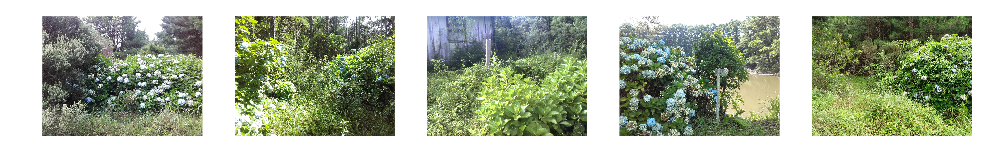

In [3]:
def show5Random(folder):
    g = glob(path + folder + '/*.jpg')
    shuf = np.random.permutation(g)
    plots([image.load_img(shuf[i]) for i in range(5)])
    
# Show a few invasive species
show5Random('valid/invasive')


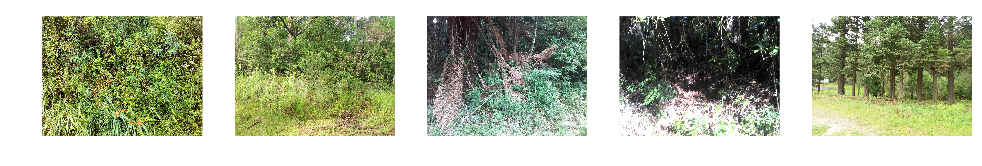

In [4]:
# Show a few non-invasive species
show5Random('valid/non-invasive')

In [5]:
vgg = Vgg16()

#Set constants. You can experiment with no_of_epochs to improve the model
batch_size=64

In [6]:
#final_path = path + 'sample/'
final_path = path

In [7]:
model_path = final_path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

In [8]:
batches = vgg.get_batches(final_path + 'train', batch_size=batch_size)
val_batches = vgg.get_batches(final_path + 'valid', shuffle=False, batch_size=batch_size)

Found 1895 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [9]:
vgg.finetune(batches)

# Training Step 1 (Train Weights from Standard VGG model)

In [10]:
def fit(id, num_epochs, lr):
    vgg.model.optimizer.lr = lr
    vgg.fit(batches, val_batches, nb_epoch=num_epochs)
    
fit(4, 6, 0.001)
fit(5, 6, 0.0001)
vgg.model.save_weights(model_path + 'train_step_1.h5')

Epoch 1/6
1895/1895 [==============================] - 94s - loss: 0.6425 - acc: 0.7757 - val_loss: 0.4421 - val_acc: 0.8300
Epoch 2/6
1895/1895 [==============================] - 73s - loss: 0.4048 - acc: 0.8554 - val_loss: 0.2301 - val_acc: 0.9000
Epoch 3/6
1895/1895 [==============================] - 76s - loss: 0.3370 - acc: 0.8697 - val_loss: 0.2100 - val_acc: 0.9150
Epoch 4/6
1895/1895 [==============================] - 77s - loss: 0.3137 - acc: 0.8734 - val_loss: 0.1916 - val_acc: 0.9200
Epoch 5/6
1895/1895 [==============================] - 72s - loss: 0.2997 - acc: 0.8860 - val_loss: 0.1874 - val_acc: 0.9275
Epoch 6/6
1895/1895 [==============================] - 68s - loss: 0.2940 - acc: 0.8765 - val_loss: 0.1916 - val_acc: 0.9300
Epoch 1/6
1895/1895 [==============================] - 90s - loss: 0.3370 - acc: 0.8723 - val_loss: 0.1721 - val_acc: 0.9400
Epoch 2/6
1895/1895 [==============================] - 75s - loss: 0.2941 - acc: 0.8850 - val_loss: 0.2282 - val_acc: 0.9000


In [11]:
vgg.model.load_weights(model_path + 'train_step_1.h5')

In [12]:
layers = vgg.model.layers

In [13]:
last_conv_id = [index for index, item in enumerate(layers) if type(item) == Convolution2D][-1]
last_conv_id

30

In [14]:
conv_layers = layers[:last_conv_id+1]
len(conv_layers)

31

In [15]:
fc_layers = layers[last_conv_id+1:]

In [16]:
conv_model = Sequential(conv_layers)
conv_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
                                                                   lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  0           zeropadding2d_1[0][0]            
                                                                   zeropadding2d_1[1][0]            
___________________________________________________________________________________________

In [39]:
batches = vgg.get_batches(final_path + 'train', shuffle=False, batch_size=batch_size)
val_batches = vgg.get_batches(final_path + 'valid', shuffle=False, batch_size=batch_size)

train_classes = batches.classes
val_classes = val_batches.classes

# Print 5 random classes
np.random.permutation(val_classes)[:5]

Found 1895 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


array([1, 0, 1, 1, 1], dtype=int32)

In [40]:
train_labels = onehot(train_classes)
val_labels = onehot(val_classes)

# Print 5 random labels
np.random.permutation(val_labels)[:5]

array([[ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.]])

# Train Step 2 (Get outputs from conv_model)

In [41]:
train_features = conv_model.predict_generator(batches, batches.nb_sample)
val_features = conv_model.predict_generator(val_batches, val_batches.nb_sample)

# Save features for later
save_array(model_path + 'train_features.bc', train_features)
save_array(model_path + 'val_features.bc', val_features)

In [42]:
# Loading checkpoint
train_features = load_array(model_path + 'train_features.bc')
val_features = load_array(model_path + 'val_features.bc')

In [43]:
val_features.shape

(400, 512, 14, 14)

In [44]:
# Create new model with no dropout
fc_model = Sequential([
    MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

# Set weights same as the model that this was based off
for l1, l2 in zip(fc_model.layers, fc_layers):
    l1.set_weights(l2.get_weights())
    
# Train slowly
opt = Adam(lr=0.00001)
fc_model.compile(optimizer=opt, metrics=['accuracy'], loss='categorical_crossentropy')

In [45]:
fc_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
maxpooling2d_7 (MaxPooling2D)    (None, 512, 7, 7)     0           maxpooling2d_input_2[0][0]       
____________________________________________________________________________________________________
flatten_3 (Flatten)              (None, 25088)         0           maxpooling2d_7[0][0]             
____________________________________________________________________________________________________
dense_8 (Dense)                  (None, 4096)          102764544   flatten_3[0][0]                  
____________________________________________________________________________________________________
dropout_5 (Dropout)              (None, 4096)          0           dense_8[0][0]                    
___________________________________________________________________________________________

# Train Step 3 (Finely tune fully connected layers)

In [46]:
# Train our model a little
fc_model.fit(train_features, train_labels, batch_size=batch_size, nb_epoch=16, validation_data=(val_features, val_labels))
fc_model.save_weights(model_path + 'no_dropout.h5')

Train on 1895 samples, validate on 400 samples
Epoch 1/16
1895/1895 [==============================] - 3s - loss: 0.2482 - acc: 0.9018 - val_loss: 0.1545 - val_acc: 0.9400
Epoch 2/16
1895/1895 [==============================] - 3s - loss: 0.1752 - acc: 0.9256 - val_loss: 0.1761 - val_acc: 0.9300
Epoch 3/16
1895/1895 [==============================] - 3s - loss: 0.1217 - acc: 0.9530 - val_loss: 0.1385 - val_acc: 0.9375
Epoch 4/16
1895/1895 [==============================] - 3s - loss: 0.1073 - acc: 0.9562 - val_loss: 0.1552 - val_acc: 0.9400
Epoch 5/16
1895/1895 [==============================] - 3s - loss: 0.0784 - acc: 0.9631 - val_loss: 0.1300 - val_acc: 0.9450
Epoch 6/16
1895/1895 [==============================] - 3s - loss: 0.0678 - acc: 0.9710 - val_loss: 0.1424 - val_acc: 0.9500
Epoch 7/16
1895/1895 [==============================] - 3s - loss: 0.0444 - acc: 0.9847 - val_loss: 0.1279 - val_acc: 0.9375
Epoch 8/16
1895/1895 [==============================] - 3s - loss: 0.0466 - ac

In [70]:
fc_model.load_weights(model_path + 'no_dropout.h5')

In [71]:
# Combine the two models
new_model = Sequential()

for conv_layer in conv_model.layers:
    conv_layer.trainable = False
    new_model.add(conv_layer)

for fc_layer in fc_model.layers:
    new_model.add(fc_layer)

In [72]:
new_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [73]:
new_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  0           zeropadding2d_1[6][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[6][0]            
___________________________________________________________________________________________

# Train Step 4 (Tune the new model)

In [75]:
batches = vgg.get_batches(final_path + 'train', batch_size=batch_size)
val_batches = vgg.get_batches(final_path + 'valid', batch_size=batch_size)

# Time to train
def train_new_model(id, nb_epochs, lr):
    new_model.optimizer.lr = lr
    new_model.fit_generator(batches, batches.nb_sample, nb_epochs, validation_data=val_batches, nb_val_samples=val_batches.nb_sample)
    
train_new_model(1, 8, 0.00001)
    
new_model.save_weights(model_path + 'final_weights.h5')

Found 1895 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Epoch 1/4
1895/1895 [==============================] - 89s - loss: 0.0040 - acc: 0.9979 - val_loss: 0.1891 - val_acc: 0.9500
Epoch 2/4
1895/1895 [==============================] - 70s - loss: 0.0029 - acc: 0.9984 - val_loss: 0.1424 - val_acc: 0.9525
Epoch 3/4
1895/1895 [==============================] - 71s - loss: 5.2001e-04 - acc: 1.0000 - val_loss: 0.2471 - val_acc: 0.9500
Epoch 4/4
1895/1895 [==============================] - 72s - loss: 3.1732e-04 - acc: 1.0000 - val_loss: 0.1241 - val_acc: 0.9650


In [76]:
new_model.load_weights(model_path + 'final_weights.h5')

# Test Step

In [78]:
%config IPCompleter.greedy=True 

test_files = get_batches(final_path + 'test', shuffle=False, batch_size=batch_size, class_mode=None)
preds = new_model.predict_generator(test_files, test_files.nb_sample)
save_array(model_path + 'final_preds.bc', preds)

Found 1531 images belonging to 1 classes.


In [79]:
preds = load_array(model_path + 'final_preds.bc')

In [80]:
preds[:5]

array([[  1.0000e+00,   7.3116e-10],
       [  5.6224e-05,   9.9994e-01],
       [  1.8866e-03,   9.9811e-01],
       [  1.0000e+00,   1.1020e-08],
       [  2.4297e-03,   9.9757e-01]], dtype=float32)

In [81]:
test_files.filenames[:5]

['unknown/779.jpg',
 'unknown/1261.jpg',
 'unknown/878.jpg',
 'unknown/552.jpg',
 'unknown/400.jpg']

In [82]:
results = zip(test_files.filenames, preds)
results[:5]

[('unknown/779.jpg', array([  1.0000e+00,   7.3116e-10], dtype=float32)),
 ('unknown/1261.jpg', array([  5.6224e-05,   9.9994e-01], dtype=float32)),
 ('unknown/878.jpg', array([ 0.0019,  0.9981], dtype=float32)),
 ('unknown/552.jpg', array([  1.0000e+00,   1.1020e-08], dtype=float32)),
 ('unknown/400.jpg', array([ 0.0024,  0.9976], dtype=float32))]

In [83]:
import re

def format(x):
    id = re.sub('unknown/([0-9]+)\.jpg', r'\1', x[0])
    return [np.int(id), np.float(x[1][0])]
    
formattedResults = np.array(map(format, results))
formattedResults[:5]

array([[  7.7900e+02,   1.0000e+00],
       [  1.2610e+03,   5.6224e-05],
       [  8.7800e+02,   1.8866e-03],
       [  5.5200e+02,   1.0000e+00],
       [  4.0000e+02,   2.4297e-03]])

In [84]:
np.savetxt('data/invasive-species-monitoring/jp_invasive.csv', formattedResults, fmt='%d,%.5f', delimiter=',', header='name,invasive', comments='')

In [85]:
from IPython.display import FileLink
FileLink('data/invasive-species-monitoring/jp_invasive.csv')

/home/ubuntu/fastai/deeplearning1/nbs/data/invasive-species-monitoring/jp_invasive.csv